# Step 2 (Web Server Log File Analysis)

## Environment Setup

### Install requirements

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

### Set environment variables

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

### Import libraries

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
import re
import datetime
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark.sql import Row

### Mount drive for log file

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Get spark context

In [ ]:
sc = spark.sparkContext

## Get Data Ready

### Extract fields from data funciton

In [ ]:
MONTH_NUMBER_MAPPING = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
                        'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}
LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+) (\S+)" (\d{3}) (\S+)'


def parse_log_time(time):
    return datetime.datetime(int(time[7:11]),
                             MONTH_NUMBER_MAPPING[time[3:6]],
                             int(time[0:2]),
                             int(time[12:14]),
                             int(time[15:17]),
                             int(time[18:20]))


def parse_single_log(log):
    match = re.search(LOG_PATTERN, log)
    if match is None:
        return (log, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = 0
    else:
        size = int(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_log_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

### Read web server log file

In [ ]:
log_file_path = '/content/drive/MyDrive/BD Logs/Log'
pure_logs = sc.textFile(log_file_path)
print("First line of log:")
print(pure_logs.first())

First line of log:
199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245


### Extract fields from data

In [ ]:
parsed_logs = (pure_logs
              .map(parse_single_log))
print("First parsed log:")
print(parsed_logs.first())
print("Paresed Logs Count: {}".format(parsed_logs.count()))

successful_parsed = (parsed_logs
                     .filter(lambda record: record[1] == 1)
                     .map(lambda record: record[0]))
print("First successfully parsed:")
print(successful_parsed.first())
print("Successful Parse Count: {}".format(successful_parsed.count()))

failed_parsed = (parsed_logs
                     .filter(lambda record: record[1] == 0)
                     .map(lambda record: record[0]))
print("First fail parsed:")
print(failed_parsed.first())
print("Failed Parse Count: {}".format(failed_parsed.count()))

First parsed log:
(Row(host='199.72.81.55', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), method='GET', endpoint='/history/apollo/', protocol='HTTP/1.0', response_code=200, content_size=6245), 1)
Paresed Logs Count: 1891715
First successfully parsed:
Row(host='199.72.81.55', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), method='GET', endpoint='/history/apollo/', protocol='HTTP/1.0', response_code=200, content_size=6245)
Successful Parse Count: 1886838
First fail parsed:
pipe6.nyc.pipeline.com - - [01/Jul/1995:00:22:43 -0400] "GET /shuttle/missions/sts-71/movies/sts-71-mir-dock.mpg" 200 946425
Failed Parse Count: 4877


### Improve log pattern

In [ ]:
LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
parsed_logs = (pure_logs
              .map(parse_single_log))
print("First parsed log:")
print(parsed_logs.first())
print("Paresed Logs Count: {}".format(parsed_logs.count()))

successful_parsed = (parsed_logs
                     .filter(lambda record: record[1] == 1)
                     .map(lambda record: record[0]))
print("First successfully parsed:")
print(successful_parsed.first())
print("Successful Parse Count: {}".format(successful_parsed.count()))

failed_parsed = (parsed_logs
                     .filter(lambda record: record[1] == 0)
                     .map(lambda record: record[0]))
print("First fail parsed:")
print(failed_parsed.first())
print("Failed Parse Count: {}".format(failed_parsed.count()))

First parsed log:
(Row(host='199.72.81.55', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), method='GET', endpoint='/history/apollo/', protocol='HTTP/1.0', response_code=200, content_size=6245), 1)
Paresed Logs Count: 1891715
First successfully parsed:
Row(host='199.72.81.55', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), method='GET', endpoint='/history/apollo/', protocol='HTTP/1.0', response_code=200, content_size=6245)
Successful Parse Count: 1890851
First fail parsed:
204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Failed Parse Count: 864


### More improvement for log pattern :D

In [ ]:
LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'
parsed_logs = (pure_logs
              .map(parse_single_log))
print("First parsed log:")
print(parsed_logs.first())
print("Paresed Logs Count: {}".format(parsed_logs.count()))

successful_parsed = (parsed_logs
                     .filter(lambda record: record[1] == 1)
                     .map(lambda record: record[0])
                     .cache())
print("First successfully parsed:")
print(successful_parsed.first())
print("Successful Parse Count: {}".format(successful_parsed.count()))

failed_parsed = (parsed_logs
                     .filter(lambda record: record[1] == 0)
                     .map(lambda record: record[0])
                     .cache())
print("First 10 fail parsed:")
print(failed_parsed.take(10))
print("Failed Parse Count: {}".format(failed_parsed.count()))

First parsed log:
(Row(host='199.72.81.55', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), method='GET', endpoint='/history/apollo/', protocol='HTTP/1.0', response_code=200, content_size=6245), 1)
Paresed Logs Count: 1891715
First successfully parsed:
Row(host='199.72.81.55', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), method='GET', endpoint='/history/apollo/', protocol='HTTP/1.0', response_code=200, content_size=6245)
Successful Parse Count: 1890866
First 10 fail parsed:
['204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502', 'nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677', 'ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -', 'gpotterpc.llnl.gov - - [

## Part 1

In [ ]:
unique_hosts = (successful_parsed
                .map(lambda log: log.host)
                .distinct())
print("First 5 hosts:")
print(unique_hosts.take(5))
unique_hosts_count = unique_hosts.count()
print("Unique hosts count: {}".format(unique_hosts_count))

First 5 hosts:
['unicomp6.unicomp.net', '129.94.144.152', 'ppptky391.asahi-net.or.jp', 'slip1.yab.com', 'pm13.j51.com']
Unique hosts count: 81971


## Part 2

### Average daily requests for each day

In [ ]:
daily_hosts = (successful_parsed
               .map(lambda log: (log.date_time.date(), log.host))
               .groupByKey()
               .sortByKey()
               .cache())
print("First 5 daily hosts:")
print(daily_hosts.take(5))

First 5 daily hosts:
[(datetime.date(1995, 7, 1), <pyspark.resultiterable.ResultIterable object at 0x7f37b1654390>), (datetime.date(1995, 7, 2), <pyspark.resultiterable.ResultIterable object at 0x7f37b0c1d4d0>), (datetime.date(1995, 7, 3), <pyspark.resultiterable.ResultIterable object at 0x7f37b0c1d7d0>), (datetime.date(1995, 7, 4), <pyspark.resultiterable.ResultIterable object at 0x7f37b0729a90>), (datetime.date(1995, 7, 5), <pyspark.resultiterable.ResultIterable object at 0x7f37b02a72d0>)]


In [ ]:
average_daily_requests = (daily_hosts
                          .map(lambda dh: (dh[0], len(dh[1])/len(set(dh[1])))))
print("Daily average reuests on each host:")
print(average_daily_requests.collect())

Daily average reuests on each host:
[(datetime.date(1995, 7, 1), 12.463405238828967), (datetime.date(1995, 7, 2), 12.401728750771763), (datetime.date(1995, 7, 3), 12.207498295841853), (datetime.date(1995, 7, 4), 12.756972111553784), (datetime.date(1995, 7, 5), 12.811162286643187), (datetime.date(1995, 7, 6), 12.91162552756107), (datetime.date(1995, 7, 7), 13.472578402595396), (datetime.date(1995, 7, 8), 13.41422160856058), (datetime.date(1995, 7, 9), 13.81159420289855), (datetime.date(1995, 7, 10), 16.31989247311828), (datetime.date(1995, 7, 11), 16.310926076360683), (datetime.date(1995, 7, 12), 17.255378858746493), (datetime.date(1995, 7, 13), 19.270896273917423), (datetime.date(1995, 7, 14), 15.880098187311178), (datetime.date(1995, 7, 15), 14.610397946084724), (datetime.date(1995, 7, 16), 15.885126162018592), (datetime.date(1995, 7, 17), 15.168318834715759), (datetime.date(1995, 7, 18), 14.211632021229544), (datetime.date(1995, 7, 19), 14.789955266368443), (datetime.date(1995, 7, 20

### Average request on each host

In [ ]:
host_requests = (successful_parsed
               .map(lambda log: (log.host, log.date_time.date()))
               .groupByKey()
               .cache())
print("First 5 host request dates:")
print(host_requests.take(5))

First 5 host request dates:
[('unicomp6.unicomp.net', <pyspark.resultiterable.ResultIterable object at 0x7f37b0c36650>), ('129.94.144.152', <pyspark.resultiterable.ResultIterable object at 0x7f37b0c36310>), ('ppptky391.asahi-net.or.jp', <pyspark.resultiterable.ResultIterable object at 0x7f37b0c36c10>), ('slip1.yab.com', <pyspark.resultiterable.ResultIterable object at 0x7f37b0c36a10>), ('pm13.j51.com', <pyspark.resultiterable.ResultIterable object at 0x7f37b0c36d10>)]


In [ ]:
average_host_daily_requests = (host_requests
                              .map(lambda dh: (dh[0], len(dh[1])/len(set(dh[1])))))
print("Daily average reuests per host:")
print(average_host_daily_requests.collect())

Daily average reuests per host:
[('unicomp6.unicomp.net', 14.0), ('129.94.144.152', 10.8), ('ppptky391.asahi-net.or.jp', 4.0), ('slip1.yab.com', 9.0), ('pm13.j51.com', 3.0), ('dd14-046.compuserve.com', 3.0), ('usr7-dialup46.chicago.mci.net', 1.0), ('teleman.pr.mcs.net', 58.0), ('isdn6-34.dnai.com', 11.0), ('ix-ftw-tx1-24.ix.netcom.com', 4.0), ('ad12-051.compuserve.com', 3.3333333333333335), ('citynet.ci.la.ca.us', 12.25), ('wwwproxy.info.au', 27.15), ('204.19.123.36', 32.0), ('piweba1y.prodigy.com', 352.42857142857144), ('204.120.76.119', 2.0), ('leet.cts.com', 9.5), ('www-b2.proxy.aol.com', 133.28571428571428), ('boing.dgsys.com', 8.0), ('204.227.13.26', 10.0), ('ip155.tmn.com', 2.0), ('ppp5.earthlight.co.nz', 7.666666666666667), ('204.248.98.63', 4.5), ('ppp6.cpbx.net', 5.25), ('blv-pm2-ip16.halcyon.com', 18.666666666666668), ('ana0013.deltanet.com', 9.0), ('202.36.46.52', 4.0), ('131.128.2.155', 19.0), ('indy2.indy.net', 20.846153846153847), ('149.171.160.182', 9.0), ('199.2.253.2',

### Number of daily request per host

In [ ]:
daily_requests = (successful_parsed
               .map(lambda log: ((log.host, log.date_time.date()), 1))
               .reduceByKey(lambda a, b: a + b))
print("First 5 daily request dates:")
print(daily_requests.take(5))

First 5 daily request dates:
[(('205.189.154.54', datetime.date(1995, 7, 1)), 11), (('alyssa.prodigy.com', datetime.date(1995, 7, 1)), 536), (('ix-orl2-01.ix.netcom.com', datetime.date(1995, 7, 1)), 3), (('gayle-gaston.tenet.edu', datetime.date(1995, 7, 1)), 18), (('gater4.sematech.org', datetime.date(1995, 7, 1)), 4)]


### Calculate daily average

In [ ]:
average_daily = (daily_requests
               .map(lambda record: (record[0][0], record[1]))
               .groupByKey()
               .mapValues(lambda reqs: sum(reqs) / len(reqs)))
print("First 5 average daily requests:")
print(average_daily.collect())

First 5 average daily requests:
[('pm13.j51.com', 3.0), ('usr7-dialup46.chicago.mci.net', 1.0), ('wwwproxy.info.au', 27.15), ('204.120.76.119', 2.0), ('199.2.253.2', 1.0), ('slip-774.netaxs.com', 5.0), ('dialup103.myriad.net', 12.0), ('ppp12.quiknet.com', 8.0), ('ix-mhl-ca1-18.ix.netcom.com', 15.0), ('securit-ext.stlnet.com', 6.333333333333333), ('phoenix.kent.edu', 5.4), ('ix-dc8-21.ix.netcom.com', 6.75), ('scooter.pa-x.dec.com', 51.25), ('204.138.186.16', 13.0), ('slper1p24.ozemail.com.au', 2.0), ('ip219.sna.primenet.com', 4.0), ('slip96-69.tx.us.ibm.net', 2.0), ('ts120.csu.bgu.edu', 15.0), ('slcan1p18.ozemail.com.au', 16.0), ('nmac.envi.osakafu-u.ac.jp', 6.0), ('194.166.8.3', 8.0), ('slper1p23.ozemail.com.au', 12.0), ('ppp07.quiknet.com', 10.4), ('fusldyn152.fusl.ac.be', 4.0), ('slip5-5.acs.ohio-state.edu', 7.0), ('slmel1p50.ozemail.com.au', 5.0), ('ana0002.deltanet.com', 5.0), ('enterprise.powerup.com.au', 8.75), ('abadon.stm.it', 13.76), ('sipc03.si.univ-compiegne.fr', 14.0), ('ka

## Part 3

In [ ]:
gif_request = (successful_parsed
               .filter(lambda log: log.endpoint.endswith('.gif')))
print("First 5 gif requests:")
print(gif_request.take(5))
gif_requests_count = gif_request.count()
print("GIF requests count: {}".format(gif_requests_count))

First 5 gif requests:
[Row(host='199.120.110.21', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 11), method='GET', endpoint='/shuttle/missions/sts-73/sts-73-patch-small.gif', protocol='HTTP/1.0', response_code=200, content_size=4179), Row(host='burger.letters.com', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 12), method='GET', endpoint='/images/NASA-logosmall.gif', protocol='HTTP/1.0', response_code=304, content_size=0), Row(host='burger.letters.com', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 12), method='GET', endpoint='/shuttle/countdown/video/livevideo.gif', protocol='HTTP/1.0', response_code=200, content_size=0), Row(host='unicomp6.unicomp.net', client_identd='-', user_id='-', date_time=datetime.datetime(1995, 7, 1, 0, 0, 14), method='GET', endpoint='/shuttle/countdown/count.gif', protocol='HTTP/1.0', response_code=200, content_size=40310), Row(host='unicomp6.unicomp.net', client_i

## Part 4

### Most requested domains

In [ ]:
IP_STARTS = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
domains_request_count = (successful_parsed
                         .filter(lambda log: log.endpoint[0] not in IP_STARTS)
                         .map(lambda log: (log.endpoint, 1))
                         .reduceByKey(lambda a, b : a + b)
                         .cache())

top_domains = domains_request_count.takeOrdered(10, lambda record: -1 * record[1])
print("Top 10 domains:")
print(top_domains)

Top 10 domains:
[('/images/NASA-logosmall.gif', 111331), ('/images/KSC-logosmall.gif', 89639), ('/images/MOSAIC-logosmall.gif', 60468), ('/images/USA-logosmall.gif', 60014), ('/images/WORLD-logosmall.gif', 59489), ('/images/ksclogo-medium.gif', 58802), ('/images/launch-logo.gif', 40871), ('/shuttle/countdown/', 40279), ('/ksc.html', 40226), ('/images/ksclogosmall.gif', 33585)]


In [ ]:
more_than_three_domains = (domains_request_count
                           .filter(lambda record: record[1]>3))
print("More than 3 requests domains:")
more_three_count = more_than_three_domains.count()
print(more_than_three_domains.takeOrdered(more_three_count, lambda record: -1 * record[1]))

More than 3 requests domains:
[('/images/NASA-logosmall.gif', 111331), ('/images/KSC-logosmall.gif', 89639), ('/images/MOSAIC-logosmall.gif', 60468), ('/images/USA-logosmall.gif', 60014), ('/images/WORLD-logosmall.gif', 59489), ('/images/ksclogo-medium.gif', 58802), ('/images/launch-logo.gif', 40871), ('/shuttle/countdown/', 40279), ('/ksc.html', 40226), ('/images/ksclogosmall.gif', 33585), ('/', 32844), ('/history/apollo/images/apollo-logo1.gif', 31072), ('/shuttle/missions/missions.html', 24864), ('/htbin/cdt_main.pl', 22626), ('/shuttle/countdown/count.gif', 22216), ('/shuttle/countdown/liftoff.html', 22000), ('/shuttle/countdown/count70.gif', 20957), ('/images/launchmedium.gif', 20812), ('/shuttle/missions/sts-71/sts-71-patch-small.gif', 19853), ('/shuttle/missions/sts-70/sts-70-patch-small.gif', 18159), ('/icons/menu.xbm', 17053), ('/icons/blank.xbm', 16795), ('/shuttle/missions/sts-71/mission-sts-71.html', 16717), ('/history/apollo/images/footprint-logo.gif', 16175), ('/shuttle/m

### Most requested domains in each day

In [ ]:
IP_STARTS = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
daily_domain_requests = (successful_parsed
                         .filter(lambda log: log.endpoint[0] not in IP_STARTS)
                         .map(lambda log: ((log.date_time.date(), log.endpoint), 1))
                         .reduceByKey(lambda a, b : a + b)                         
                         .cache())

top_domains = daily_domain_requests.takeOrdered(10, lambda record: -1 * record[1])
print("Top 10 domains:")
print(top_domains)

Top 10 domains:
[((datetime.date(1995, 7, 13), '/images/NASA-logosmall.gif'), 12098), ((datetime.date(1995, 7, 12), '/images/NASA-logosmall.gif'), 7350), ((datetime.date(1995, 7, 13), '/htbin/cdt_main.pl'), 6613), ((datetime.date(1995, 7, 6), '/images/NASA-logosmall.gif'), 6227), ((datetime.date(1995, 7, 5), '/images/NASA-logosmall.gif'), 6175), ((datetime.date(1995, 7, 13), '/htbin/cdt_clock.pl'), 5961), ((datetime.date(1995, 7, 13), '/images/KSC-logosmall.gif'), 5717), ((datetime.date(1995, 7, 3), '/images/NASA-logosmall.gif'), 5573), ((datetime.date(1995, 7, 11), '/images/NASA-logosmall.gif'), 5274), ((datetime.date(1995, 7, 6), '/images/KSC-logosmall.gif'), 5204)]


In [ ]:
daily_top_domain = (daily_domain_requests
                    .map(lambda log: (log[0][0], (log[1], log[0][1])))
                    .groupByKey()
                    .map(lambda x : (x[0], sorted(list(x[1]), reverse=True)))
                    .cache())

print(daily_top_domain.take(5))

[(datetime.date(1995, 7, 3), [(5573, '/images/NASA-logosmall.gif'), (4655, '/images/KSC-logosmall.gif'), (3666, '/shuttle/countdown/count.gif'), (3534, '/shuttle/countdown/'), (2296, '/images/ksclogo-medium.gif'), (2235, '/images/MOSAIC-logosmall.gif'), (2225, '/images/USA-logosmall.gif'), (2175, '/images/WORLD-logosmall.gif'), (1927, '/shuttle/missions/sts-71/sts-71-patch-small.gif'), (1911, '/shuttle/missions/sts-71/images/images.html'), (1798, '/images/launch-logo.gif'), (1688, '/shuttle/missions/sts-71/mission-sts-71.html'), (1650, '/shuttle/countdown/video/livevideo.gif'), (1637, '/ksc.html'), (1480, '/images/ksclogosmall.gif'), (1241, '/'), (1221, '/shuttle/countdown/liftoff.html'), (1113, '/shuttle/missions/missions.html'), (906, '/images/launchmedium.gif'), (731, '/icons/menu.xbm'), (731, '/icons/blank.xbm'), (715, '/history/apollo/images/footprint-logo.gif'), (684, '/history/apollo/images/footprint-small.gif'), (677, '/history/apollo/apollo-13/apollo-13.html'), (671, '/history

In [ ]:
top_domains = (daily_top_domain
               .map(lambda day_record: (day_record[0], day_record[1][0])))

print("Daily top domain:")
top_domains.collect()

Daily top domain:


[(datetime.date(1995, 7, 3), (5573, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 6), (6227, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 9), (1463, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 24), (3362, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 25), (3380, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 28), (1555, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 2), (3416, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 13), (12098, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 14), (4876, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 1), (3977, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 15), (2411, '/images/KSC-logosmall.gif')),
 (datetime.date(1995, 7, 16), (2330, '/images/KSC-logosmall.gif')),
 (datetime.date(1995, 7, 5), (6175, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 10), (3740, '/images/NASA-logosmall.gif')),
 (datetime.date(1995, 7, 11), (5274, '/im

## Part 5

### Find Error Logs

In [ ]:
http_errors = (successful_parsed
               .filter(lambda log: log.response_code!=200)
               .map(lambda log: (log.response_code, 1))
               .cache())
print("First 5 errors:")
print(http_errors.take(5))

First 5 errors:
[(304, 1), (304, 1), (304, 1), (302, 1), (404, 1)]


### Count errors

In [ ]:
error_counts = (http_errors
                .reduceByKey(lambda a, b: a + b))
print("Error counts:")
print(error_counts.collect())

Error counts:
[(302, 46569), (304, 132626), (500, 62), (403, 54), (501, 14), (404, 10784)]


### Draw status code frequency bar plot

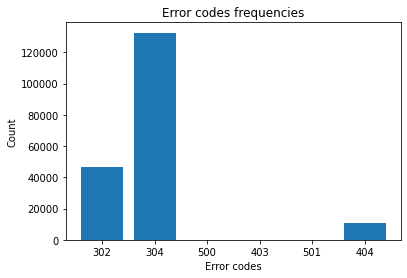

In [ ]:
status_codes = []
code_frequencies = []
for error, count in error_counts.collect():
  status_codes.append(str(error))
  code_frequencies.append(count)

plt.title("Error codes frequencies")
plt.xlabel("Error codes")
plt.ylabel("Count")
plt.bar(status_codes, code_frequencies)
plt.show()